# Preproccessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

key_variables = ['Runtime', 'Total Energy', 'Power', 'Peak Memory', 'Final Temp']

path = '/Users/hatim/Documents/Projects/Comp/Aggredated Data/'
languages = ['C', 'C++', 'Java', 'Python']


df = pd.DataFrame()

for language in languages:
    data = pd.read_csv(path+language+'.csv')
    # drop mid_temp
    data = data.drop(['mid_temp'], axis=1)
    # rearrange columns
    data['Language'] = language
    df = pd.concat([df, data], ignore_index=True)

# convert version to strings
df['Version'] = df['Version'].astype(str)
# create columns for Total Energy, Power, 
df['Total Energy'] = df['package']+df['dram']
df['Power'] = df['Total Energy']/df['duration']
# rename duration to Runtime, and peak rss to peak memory
df = df.rename(columns={'duration':'Runtime', 'peak_rss':'Peak Memory', 'final_temp': 'Final Temp'})
df = df[['Language','Algorithm', 'Version', 'Runtime', 'Total Energy', 'Peak Memory', 'Power', 'Final Temp']]


df.head()



/var/folders/sx/705n1pb94rq1x2q_s1l8lfv80000gn/T/ipykernel_80333/1141522846.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Language,Algorithm,Version,Runtime,Total Energy,Peak Memory,Power,Final Temp
0,C,spectralnorm,3.7,683572.806,8705788.0,2220,12.735714,45.0
1,C,spectralnorm,3.7,658340.052,8836098.0,2204,13.421784,65.0
2,C,spectralnorm,3.7,680261.075,8630654.0,2208,12.687267,45.0
3,C,spectralnorm,3.7,658267.766,8748391.0,2216,13.290019,63.0
4,C,spectralnorm,3.7,680408.705,8653238.0,2216,12.717706,45.0


## Quantifying variability

In [3]:
# too long and difficult to summarize

df_std = df.groupby(['Language', 'Algorithm', 'Version'])[['Runtime', 'Total Energy', 'Peak Memory', 'Power']].std().reset_index()
# df_std = df_std.groupby(['Language', 'Algorithm'])[['Runtime', 'Total Energy', 'Peak Memory', 'Power']].std()


df_std.head()

,Language,Algorithm,Version,Runtime,Total Energy,Peak Memory,Power
0,C,bintrees,10.0,110282.111211,9.084204e+05,2.108185,0.680610
1,C,bintrees,11.1,101617.915601,8.213805e+05,1.932184,0.537275
2,C,bintrees,12.0,80227.330685,1.009130e+06,2.108185,0.466171
3,C,bintrees,13.0,101120.786134,3.761913e+05,1.932184,0.551072
4,C,bintrees,14.0,129135.322473,4.262458e+05,1.932184,0.615160


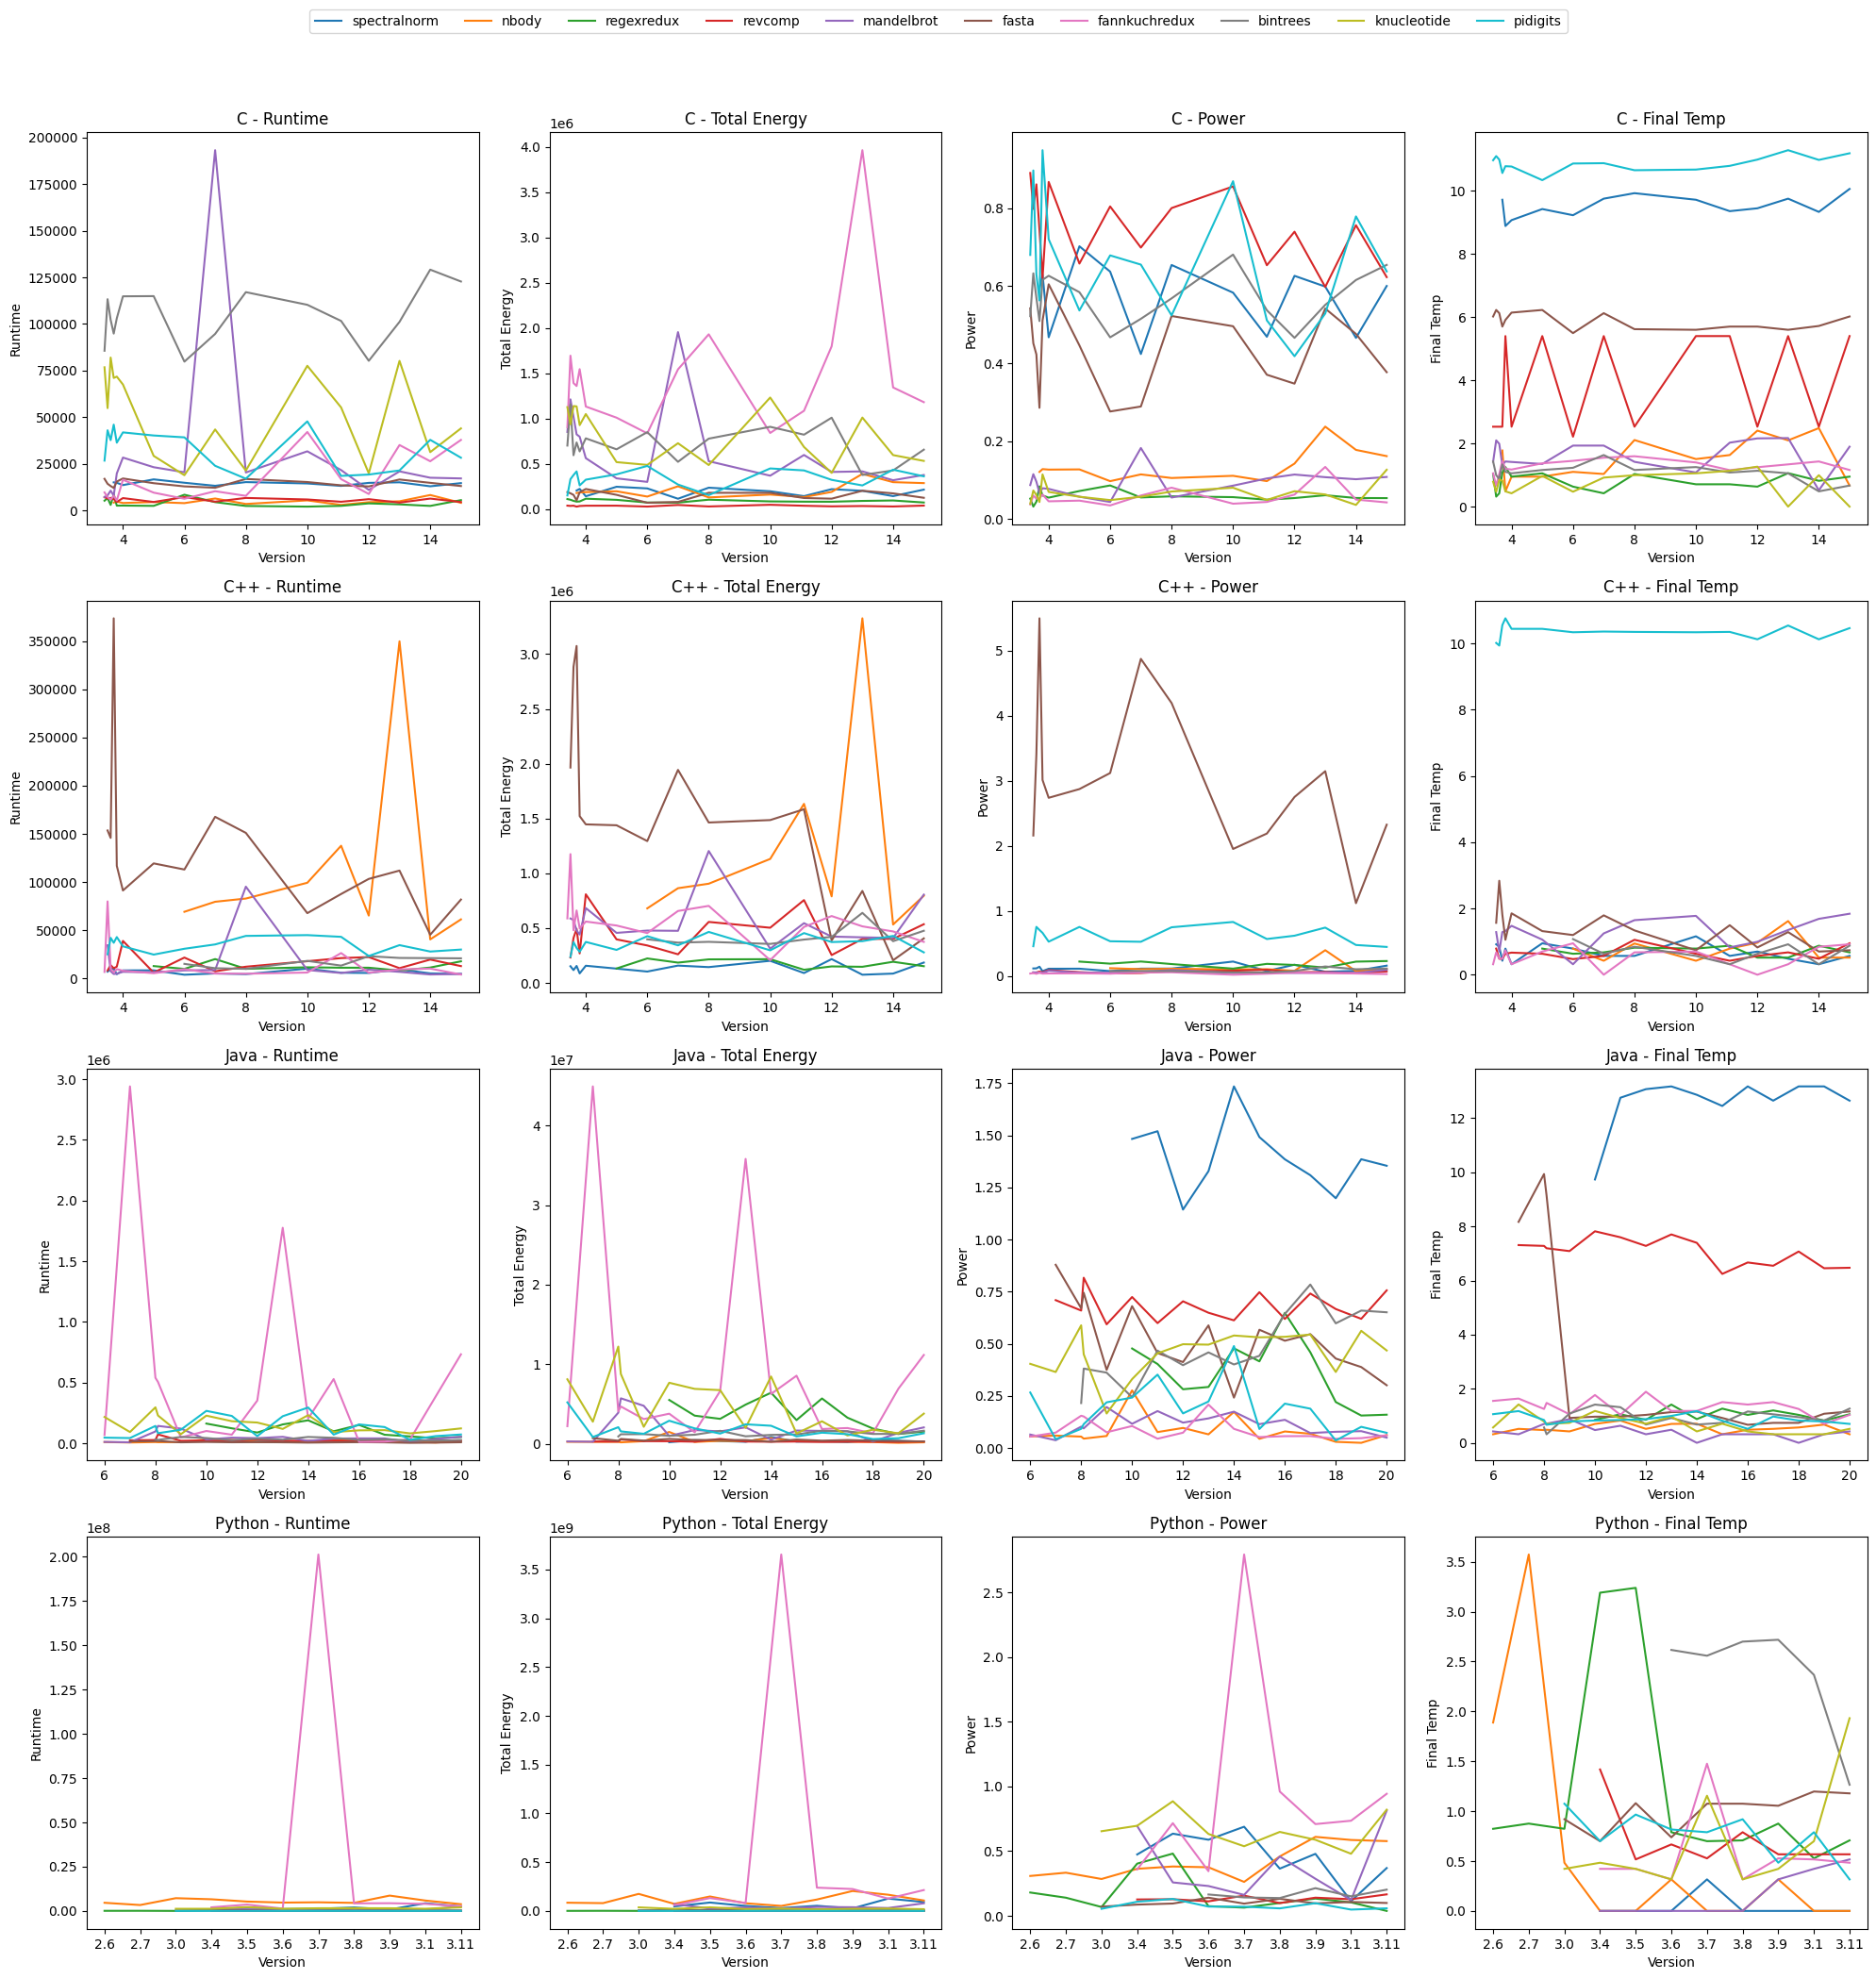

In [15]:
import warnings
warnings.filterwarnings('ignore')

def plot_std_dev_by_language(df):
    languages = df['Language'].unique()
    algorithms = df['Algorithm'].unique()
    metrics = ['Runtime', 'Total Energy', 'Power', 'Final Temp']
    python_order = ['2.6', '2.7', '3.0',  '3.4', '3.5', '3.6', '3.7', '3.8', '3.9','3.1', '3.11']

    # Number of rows and columns for the subplot
    nrows = len(languages)
    ncols = len(metrics)

    # Create a large figure to hold all the subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    
    # Ensure axes is a 2D array for easy indexing
    if nrows == 1:
        axes = np.array([axes])

    for i, language in enumerate(languages):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]  # Select the correct subplot
            for algo in algorithms:
                # Filter data for each language-algorithm-version
                subset = df[(df['Language'] == language) & (df['Algorithm'] == algo)].copy()
                
                # Sort versions; custom sort for Python
                if language == 'Python':
                    subset = subset[subset['Version'].isin(python_order)]
                    subset['Version'] = pd.Categorical(subset['Version'], categories=python_order, ordered=True)
                else:
                    subset['Version'] = pd.to_numeric(subset['Version'], errors='coerce')
                subset.sort_values(by='Version', inplace=True)
                

                # Calculate standard deviation for each version
                std_devs = subset.groupby('Version')[metric].std()
                ax.plot(std_devs, label=algo)
            
            ax.set_title(f'{language} - {metric}')
            ax.set_xlabel('Version')
            ax.set_ylabel(metric)
    fig.legend(algorithms, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=10)
    plt.tight_layout()
    plt.show()

plot_std_dev_by_language(df)



In [17]:
from scipy.stats import linregress
# General function for regression analysis on a given variable
def analyze_usage_trends(df, languages, variable):
    analysis_results = {}
    for language in languages:
        language_data = df[df['Language'] == language]
        algorithms = language_data['Algorithm'].unique()
        for algo in algorithms:
            algo_data = language_data[language_data['Algorithm'] == algo]
            std_dev = algo_data[variable].std()
            mean_data_by_version = algo_data.groupby('Version')[variable].std().reset_index()
            slope, intercept, r_value, p_value, std_err = linregress(mean_data_by_version.index, mean_data_by_version[variable])
            analysis_results[f"{language}_{algo}"] = {
                'Standard Deviation': std_dev,
                'Slope of Trend': slope,
                'p-value of Trend': p_value
            }
    return analysis_results

# General function to filter and create a table of significant trends
def filter_significant_trends(analysis_results, significance_level=0.05):
    filtered_results = []
    for identifier, metrics in analysis_results.items():
        if metrics['p-value of Trend'] < significance_level:
            language, algo = identifier.split("_")
            filtered_results.append({
                'Language': language,
                'Algorithm': algo,
                'Standard Deviation': metrics['Standard Deviation'],
                'Slope of Trend': metrics['Slope of Trend'],
                'p-value of Trend': metrics['p-value of Trend']
            })
    return pd.DataFrame(filtered_results)

languages = ['C', 'C++', 'Java', 'Python']
variables = ['Runtime', 'Total Energy', 'Power', 'Peak Memory', 'Final Temp']

var_dict = {}
for var in variables:
    print(f"Analyzing {var}...")
    usage_trends = analyze_usage_trends(df, languages, var)
    var_dict[var] = filter_significant_trends(usage_trends)

Analyzing Runtime...
Analyzing Total Energy...
Analyzing Power...
Analyzing Peak Memory...
Analyzing Final Temp...


In [23]:
res = pd.DataFrame()
for var in var_dict.keys():
    var_df = var_dict[var]
    var_df['Variable'] = var
    res = pd.concat([res, var_df], ignore_index=True)
res= res[res['Slope of Trend']<0] # filter out negative trends

res = res[['Language', 'Algorithm', 'Variable','Slope of Trend']]
res.to_csv('significant_trends.csv', index=False)

    Language Algorithm Version        Runtime  Total Energy     Power  \
419   Python  bintrees     3.1  203087.910670  5.937458e+06  0.150731   
420   Python  bintrees    3.11  160622.738054  4.412939e+06  0.202401   
421   Python  bintrees     3.6  419566.021086  1.447101e+07  0.164959   
422   Python  bintrees     3.7  225410.622065  8.967819e+06  0.142192   
423   Python  bintrees     3.8  260040.265810  1.134617e+07  0.137484   
424   Python  bintrees     3.9  257896.168634  8.246000e+06  0.213821   

     Final Temp  
419    2.366432  
420    1.264911  
421    2.616189  
422    2.558211  
423    2.699794  
424    2.718251  
    Language      Algorithm Version       Runtime  Total Energy     Power  \
425   Python  fannkuchredux     3.1  3.994884e+06  1.264393e+08  0.734807   
426   Python  fannkuchredux    3.11  2.574312e+06  2.140599e+08  0.942932   
427   Python  fannkuchredux     3.4  2.036978e+06  5.933450e+07  0.358705   
428   Python  fannkuchredux     3.5  3.589819e+06  1.3

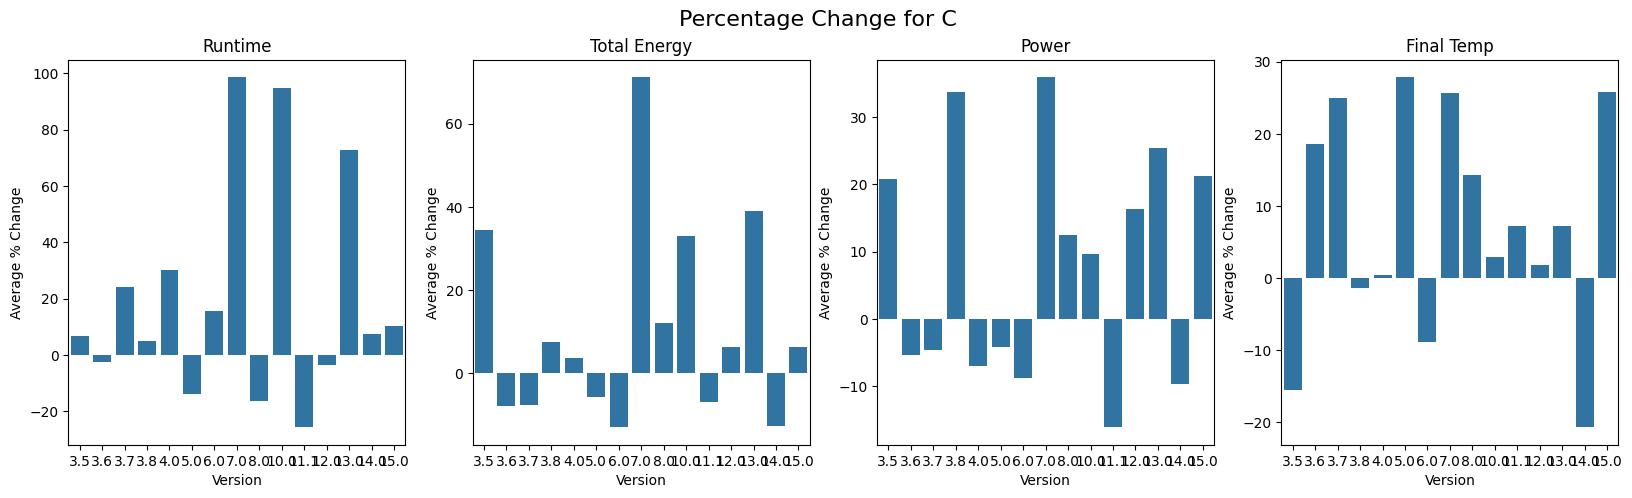

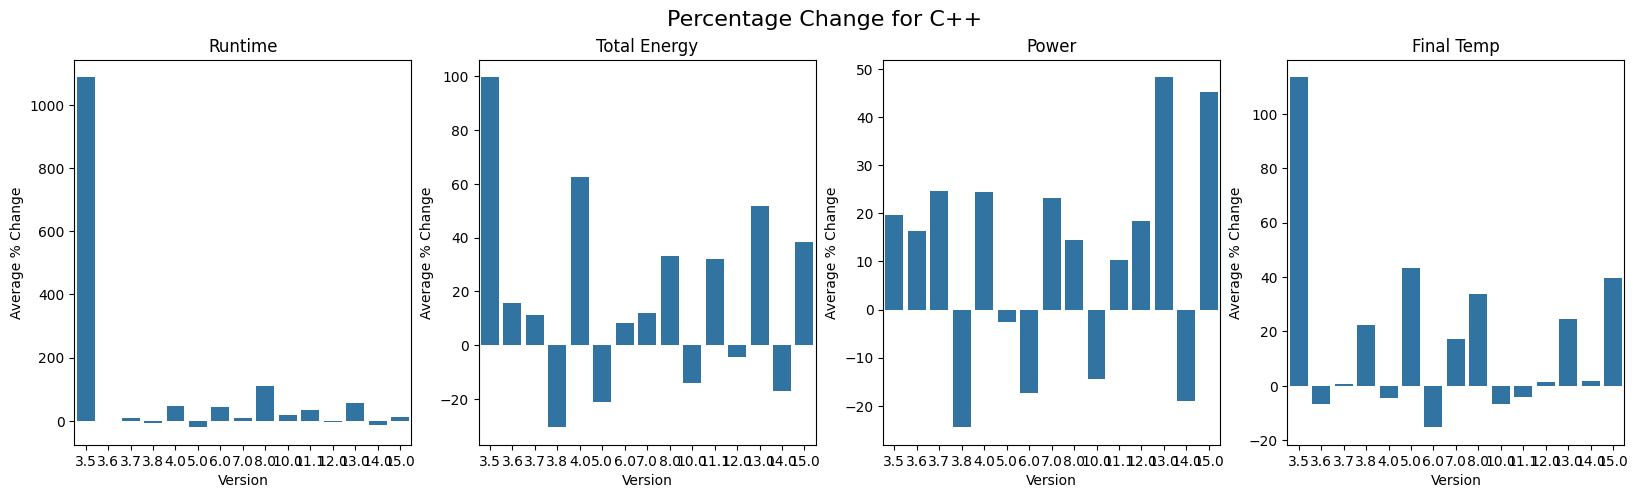

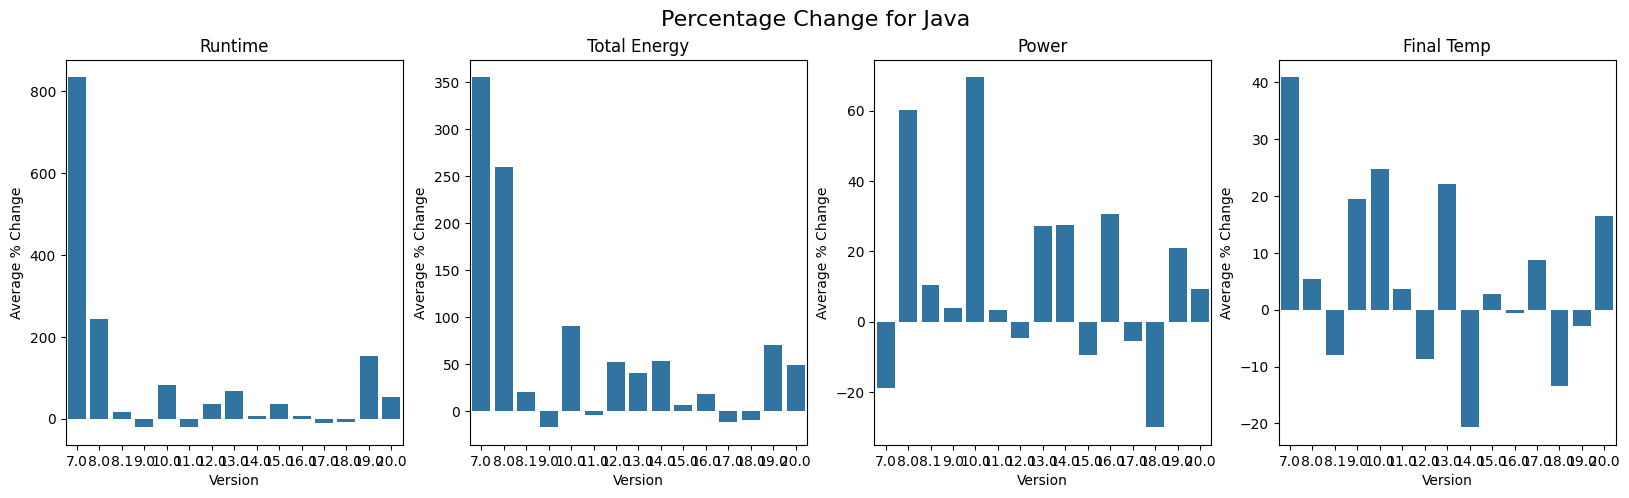

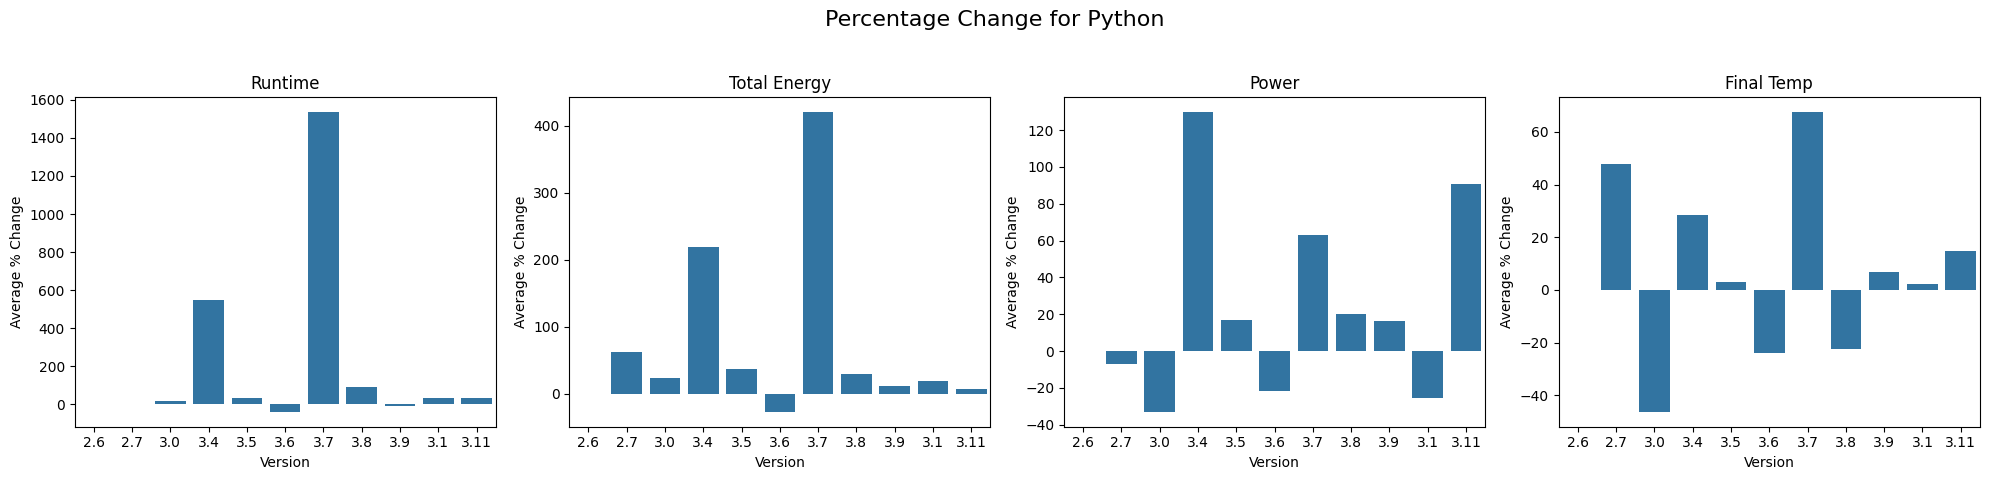

In [31]:

def percentage_change(df_std):
    python_order = ['2.6', '2.7', '3.0',  '3.4', '3.5', '3.6', '3.7', '3.8', '3.9','3.1', '3.11']
    algorithms = df_std['Algorithm'].unique()
    languages = df_std['Language'].unique()
    
    df_average_percentage_change = pd.DataFrame()

    for language in languages:
        for algo in algorithms:
            subset = df_std[(df_std['Language'] == language) & (df_std['Algorithm'] == algo)].copy()
            
            # Sort the subset by version
            if language == 'Python':
                subset['Version'] = subset['Version'].astype(str)
                subset = subset[subset['Version'].isin(python_order)]
                subset['Version'] = pd.Categorical(subset['Version'], categories=python_order, ordered=True)
            else:
                subset['Version'] = pd.to_numeric(subset['Version'], errors='coerce')
            subset.sort_values(by='Version', inplace=True)
            # Initialize an empty list to store each row's data
            rows = []

            # Calculate percentage change across adjacent versions
            for i in range(1, len(subset)):
                
                from_version = subset.iloc[i-1]['Version']
                to_version = subset.iloc[i]['Version']

                pct_change_data = {
                    'Language': language,
                    'Algorithm': algo,
                    'from_version': from_version,
                    'to_version': to_version
                }

                for metric in ['Runtime', 'Total Energy', 'Power', 'Final Temp']:
                    from_value = subset.iloc[i-1][metric]
                    to_value = subset.iloc[i][metric]
                    pct_change = ((to_value - from_value) / from_value) * 100 if from_value != 0 else np.nan
                    pct_change_data[metric] = pct_change

                # Append the data for this row to the list
                rows.append(pct_change_data)

            # Concatenate the rows to the main DataFrame
            df_average_percentage_change = pd.concat([df_average_percentage_change, pd.DataFrame(rows)], ignore_index=True)
    
    df_average_percentage_change = df_average_percentage_change.groupby(['Language', 'to_version'])[['Runtime', 'Total Energy','Power', 'Final Temp']].mean()
    return df_average_percentage_change

def plot_change(df):
    df_percentage_change = percentage_change(df)
    df_percentage_change = df_percentage_change.reset_index()

    python_order = ['2.6', '2.7', '3.0',  '3.4', '3.5', '3.6', '3.7', '3.8', '3.9','3.1', '3.11']

    languages = df_percentage_change['Language'].unique()
    metrics = ['Runtime', 'Total Energy', 'Power', 'Final Temp']


    for language in languages:
        fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
        fig.suptitle(f'Percentage Change for {language}', fontsize=16)

        language_data = df_percentage_change[df_percentage_change['Language'] == language]
        if language == 'Python':
            language_data['to_version'] = pd.Categorical(language_data['to_version'], categories=python_order, ordered=True)


        for i, metric in enumerate(metrics):
            sns.barplot(ax=axes[i], x='to_version', y=metric, data=language_data)
            axes[i].set_title(metric)
            axes[i].set_xlabel('Version')
            axes[i].set_ylabel('Average % Change')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusting layout to fit the suptitle
    plt.show()


df_std = df.groupby(['Language', 'Algorithm', 'Version'])[['Runtime', 'Total Energy', 'Power', 'Final Temp']].std().reset_index()

plot_change(df_std)
            